In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from numba import njit,prange
import random

In [11]:

def KC_LZ(string):
    n = len(string)
    s = '0'+string
    c = 1
    l = 1
    i = 0
    k = 1
    k_max = 1

    while True:
        if s[i+k] != s[l+k]:
            if k > k_max:
                k_max = k
            i += 1
            if i == l:
                c += 1
                l += k_max
                if l+1 > n:
                    break
                else:
                    i = 0
                    k = 1
                    k_max = 1
            else:
                k = 1
        else:
            k += 1
            if l+k > n:
                c += 1
                break
    # a la Lempel and Ziv (IEEE trans inf theory it-22, 75 (1976),
    # h(n)=c(n)/b(n) where c(n) is the kolmogorov complexity
    # and h(n) is a normalised measure of complexity.
    complexity = c
    # b=n*1.0/np.log2(n)
    # complexity=c/b;
    return complexity


In [12]:
def calc_KC(s):
    L = len(s)
    if s == '0'*L or s == '1'*L:
        return np.log2(L)
    else:
        return np.log2(L)*(KC_LZ(s)+KC_LZ(s[::-1]))/2.0

In [14]:
@njit
def discretize(arr):
    return list(map(round,arr))
@njit
def to_bin(arr):
    return ''.join(list(map(str,arr)))

@njit
def f(x,r):
    return r * x * (1-x)

@njit
def logistic_map(x_0,r,iterations,epsilon=0,e_freq=0):
    assert r>0 
    assert r < 4
    res = [x_0]
    cur = x_0
    for i in range(iterations-1):
        cur = f(cur,r)

        # When kick occurs
        if np.random.rand() < e_freq:
            added_eps = np.random.uniform(-epsilon,epsilon)
            # Keep sampling for epsilon until we get a valid value
            while  0>= cur + added_eps or cur + added_eps>=1:
                added_eps = np.random.uniform(-epsilon,epsilon)
            cur += added_eps
        assert 0< cur <1
        res.append(cur)
    return res

In [15]:
SAMPLES = 10**5

@njit
def generate_patterns(iterations,epsilon=0,e_freq=0,r=-1):

    '''Return list of patterns  from random `r` and `x_0`. patterns are of length `iterations`
        If r parameter is provided it will use that as the initial value of r, otherwise it will be random.
    
    '''
    r_is_random = r == -1
    patterns = [''] *(SAMPLES) 
    for i in prange(SAMPLES):
        if (r_is_random):
            r = random.uniform(0,4)
        x_0 = np.random.rand()
        mapp = logistic_map(x_0,r,iterations,epsilon=epsilon,e_freq=e_freq)
        patterns[i] = to_bin(discretize(mapp))
    return patterns


In [16]:
def generate_logistic(iterations,start_iteration=0,epsilon=0,e_frequency=0,r=-1):
    ''' Wrapper function for logicstic map generation with kick.

    Parameters:
        `iterations`: the number of iterations that will be taken into account, this will determine the length of the pattern.
        `start_iteration`: after what iteration to start observing the pattern. defaults to `0`.
        `epsilon`: The magnitude of the random kick applied, when 0.5 is passed, the kick will be between -0.5,0.5. default to 0
        `e_frequency`: Nonnegative number determining the frequency of the kick. defaults to 0.
                       If the number is in the range [0,1), this is a probability.
    '''
                       # Otherwise it represents the frequency of the kick (1 means every time, 2 means every two time [nokick,kick,nokick,kick]) NOT IMPLEMENTED
    patterns = generate_patterns(start_iteration+iterations,epsilon=epsilon,e_freq=e_frequency,r=r)
    patterns = [ pattern[start_iteration:] for pattern in patterns]
    return patterns

In [ ]:
@njit
def calc_SB(X,y):
     return np.polyfit(X,y,1);

In [17]:
n_iterations = 25
start_iteration=1000
epsilon = 0.5
e_frequency = 0.1
r =3

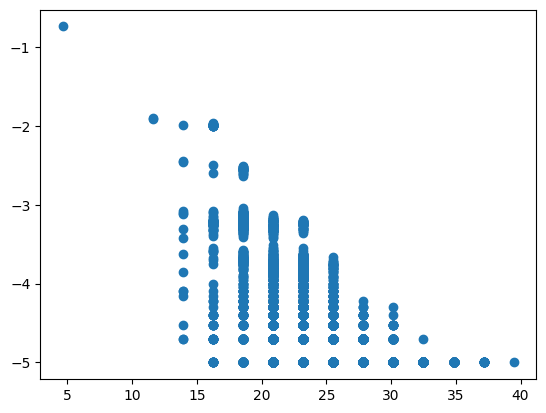

In [18]:
# Generate figure for each epsilon value
# %prun generate_logistic(n_iterations,start_iteration=1000,epsilon=epsilon,e_frequency=e_frequency,r=r)
patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
counts = Counter(patterns)

probability = counts.copy()
probability = {k: v/SAMPLES for k,v in probability.items()}

probability_values =  list(probability.values())
complexities = list(map(calc_KC,probability.keys()))
plt.figure()
plt.scatter(complexities,np.log10(probability_values))
# # plt.savefig(f"fixed_r/{r}.png")
import pandas as pd
results = []
for n_iterations in [50,100,150]:
    for start_iteration in [1000]:
        for epsilon in [0.01,0.1,0.25,0.4,0.5,0.75]:
            for e_frequency in [0.1,0.5,1]:
                for r in [-1,2,2.5,3,3.65]:
                    patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
                    probability = Counter(patterns)
                    probability = {k: v/SAMPLES for k,v in probability.items()}

                    probability_values =  list(probability.values())
                    complexities = list(map(calc_KC,probability.keys()))

                    df = pd.DataFrame({"y":probability_values,'x':complexities})
                    groupmax = df.groupby('x').max().reset_index()
                    ar = calc_SB(groupmax['x'],np.log10(groupmax['y']))#
                    slope = ar[0]
                    print([start_iteration,epsilon,e_frequency,r,slope])
                    results.append([start_iteration,epsilon,e_frequency,r,slope])